In [1]:
import numpy as np
import pandas as pd
from rpy2.robjects import r
import rpy2.robjects.pandas2ri as pandas2ri
pandas2ri.activate() #MANDATORY !
file = "~/govWebsites/rfiles/d.Rdata"
rf = r['load'](file)
d = r['d']
X = d['doc']

In [2]:
#Binarize y
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(d['winner']).ravel()

In [3]:
#test-training split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state = 123)

In [5]:
#Pre-processing and SVM pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=0.00005, random_state=42)),
])

/usr/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [6]:
#fit and predict
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)

In [7]:
#accuracy
from sklearn import metrics
print(metrics.classification_report(y_test, predicted, target_names=['Democrat','Republican']))

             precision    recall  f1-score   support

   Democrat       0.90      0.94      0.92      1034
 Republican       0.88      0.81      0.85       578

avg / total       0.89      0.89      0.89      1612



In [8]:
#Grid search
from sklearn.model_selection import GridSearchCV
parameters = {'clf__alpha': (0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_score_

0.89092664092664098

In [9]:
#best parameters from grid search
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 5e-05


In [10]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, drop_intermediate = False)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)
thresholds

array([2, 1, 0])

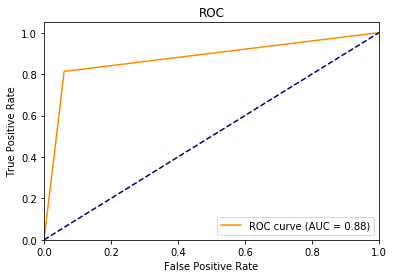

In [11]:
#ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (AUC = %0.2f)'  % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.model_selection import cross_val_score
fitobj = text_clf.fit(X, y)
scores = cross_val_score(fitobj, X, y, cv=5)

In [13]:
np.mean(scores)

0.89929357420772715

In [14]:
results = text_clf.fit(X_train, y_train)

In [15]:
a = text_clf.fit(X_train, y_train).steps

In [16]:
a[2][1].coef_.shape

(1, 34401)

In [17]:
X_train.shape

(14504,)